In [7]:
# imports 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] # gross, but works

from figure_style import *
from Dragonfly44_SFH.utils.styles import *

In [2]:
path_data = path_base+ "Dragonfly44_SFH/data/"

run_params = {
              'sfh': 3,

              'nbins': 12,
              'tlims_first': [0.03, 0.1, 0.5, 1., 2., 3],
              'tlims_logspace': True,

              'file_data': path_data+"Dragonfly44/obs_phot_specKCWI_sigma110.h5",

              'fit_sigma':    False, # whether to fit for the smoothing parameters (False usually)
              'fit_logzsol':  True, # Whether metallicity is a free or fixed parameter
              'fit_mass':  True, # Whether mass is a free or fixed parameter

              'fit_redshift':     False, # Whether redshift is a free or fixed parameter

              'fit_spectra':      True, # Fit spectroscopy?
              'fit_phot':         True, # Fit photometry?

              'npoly': 3, # Degress of Chebyshev polynomial for specphot calibratino

              'opt_polynomial':   True, # whether to optimize a polynomial ratio between F_true and F_obs
              'fit_polynomial':   False, # whether to fit for a polynomial ratio between F_true and F_obs (ie includes prior)
              'rescale_spectrum': False, # If True, rescale the spectrum to have an average of 1 before doing anything.

              'fit_agn':     False, # fit agn emission
              'fit_duste':   True, # fit dust emission
              'fit_neb':     False, # fit nebular emission

              'fit_outlier_spec': True, # fit for outliers in spectroscopy
              'fit_noise_spec':   True, # Jitter parameter

              'wave_range': [3000,10000],
              'max_snr': 10000000,
              }

In [3]:
from Dragonfly44_SFH.fitting.input.param_fit_setup import *

model_aD1 = build_model( alphaD=1, **run_params )
model_aD02 = build_model( alphaD=0.2, **run_params )

In [4]:
# draw from priors
ndraws = int(1e4)
ndraws = int(1e2)

from Dragonfly44_SFH.utils.prospect_io import get_sfh_priors

prior_draws_aD1 = get_sfh_priors( model_aD1, ndraws )
prior_draws_aD02 = get_sfh_priors( model_aD02, ndraws )

prior_draws_aD1['label'] = r'Dirichlet $\alpha_\mathrm{D}=1$ (extended)'
prior_draws_aD02['label'] = r'Dirichlet $\alpha_\mathrm{D}=0.2$ (concentrated)'


prior_draws_aD1['color'] = color_aD1
prior_draws_aD02['color'] = color_aD02

# calculate mass-weighted ages

from Dragonfly44_SFH.utils.transforms import sfr_to_mwa

prior_draws_aD1['mwa'] = sfr_to_mwa( model_aD1.params['agebins'], sfrs=prior_draws_aD1['sfr'] )
prior_draws_aD02['mwa'] = sfr_to_mwa( model_aD02.params['agebins'], sfrs=prior_draws_aD02['sfr'] )

In [5]:
# check to make sure agebinning consistent
np.all( model_aD1.params['agebins'] == model_aD02.params['agebins'] )

True

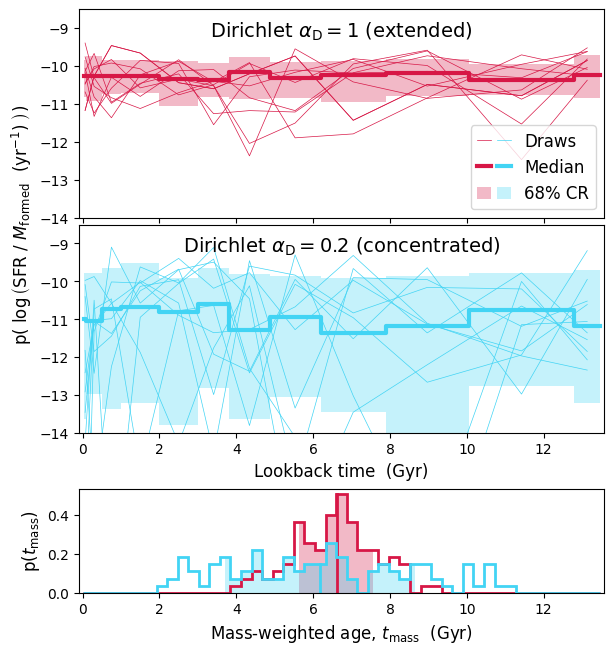

In [9]:
fig, axes = plt.subplots(4,1, figsize=(fig_width_one, textheight*0.4), 
                         gridspec_kw=dict( height_ratios=[1,1,0.2,0.5]) )
ax_sfh_aD1, ax_sfh_aD02, ax_off, ax_mwa = axes
ax_off.axis('off')

agebins_Gyr = np.power(10, model_aD1.params['agebins']-9)
x = np.unique( agebins_Gyr )
mx = np.median(agebins_Gyr, axis=1 )

quantiles = [0.5, 0.16, 0.84] # if changing, relabel legend 
    
legend_items = { 'draws':[], 'medians':[], 'CRs':[] }    
for ax,prior_draws in  [[ax_sfh_aD1,prior_draws_aD1], [ax_sfh_aD02,prior_draws_aD02]]:
    
    # SFHs 
    qs = np.array([ np.quantile( x, q=quantiles )
                    for x in prior_draws['ssfr'].T ]).T
    qs50, qs1, qs2 = np.log10(qs)

    l, = ax.step( x, np.append( qs50, qs50[-1] ),
                 where='post', zorder=2, color=prior_draws['color'], lw=3,
               )
    legend_items['medians'] =  legend_items['medians']+[l]

    l = ax.fill_between( x, np.append( qs1, qs1[-1] ), np.append( qs2, qs2[-1] ),
                         alpha=0.3, step='post', lw=0, zorder=1,
                         color=prior_draws['color'], 
                       )
    legend_items['CRs'] =  legend_items['CRs']+[l]
    
    ax.annotate( prior_draws['label'], xy=(0,0), xytext=(0.5,0.95), 
                 xycoords='axes fraction', va='top', ha='center', fontsize=14)
    
    # random draws from prior
    for y in np.log10( prior_draws['ssfr'][ np.random.choice( ndraws, size=10 ),:] ):
        l, = ax.plot( mx, y,
                     color=prior_draws['color'], lw=0.5
                   )
    legend_items['draws'] =  legend_items['draws']+[l]
        
    # mwa
    n,b,_ = ax_mwa.hist( prior_draws['mwa'], 
                 bins=np.linspace(0, x[-1], 50),
                 color=prior_draws['color'], histtype='step',
                 lw=2, density=True,
               )
    mb = b[:-1] + np.diff(b)/2. # bin centers
    qs50, qs1, qs2 = np.quantile( prior_draws['mwa'], quantiles )
    
    ymax = n[np.argmin(np.abs(mb-qs50))]
    ax_mwa.plot( [qs50,qs50], [0, ymax ],
                 color=prior_draws['color'], lw=2,
                )
    sel = (qs1 <= mb) & (mb <= qs2)
    ax_mwa.fill_between( mb[sel], n[sel]*0, n[sel], 
                         color=prior_draws['color'], lw=0, alpha=0.3, step='mid',
                       )
    
    ax.set_xlim(-0.1, x[-1]+0.1)
    ax.set_ylim(-14,-8.5)
    ax_mwa.set_xlim(-0.1, x[-1]+0.1)
    
if True: # labels     
    ax_sfh_aD1.set_xticklabels([])
    ax_sfh_aD02.set_xlabel('Lookback time  (Gyr)')
    ax_sfh_aD02.set_ylabel(r'p( {})'.format(parameter_labels_with_units['log_ssfr']), y=1)
    ax_mwa.set_xlabel('Mass-weighted age, {}'.format( parameter_labels_with_units['mwa'] ))
    ax_mwa.set_ylabel('p({})'.format( parameter_labels['mwa'] ))

if True: # legend  
    handles = [ tuple(legend_items['draws']), 
                tuple(legend_items['medians']), 
                tuple(legend_items['CRs'] )]
    labels = ['Draws','Median','68% CR']
    ax_sfh_aD1.legend( handles, labels, 
                       loc=4,
                       handler_map={tuple: HandlerTuple(ndivide=None)}, 
                       markerscale=0.5,
                     )
    
fig.subplots_adjust(hspace=0.05)
plt.show()